<a href="https://colab.research.google.com/github/Storm00212/Introduction-to-machine-learning-models/blob/main/DecisionTrees%26RandomForestStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier,plot_tree,export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,accuracy_score
import matplotlib
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pathlib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [2]:
pip install opendatasets

### Loading the dataset...

In [4]:
#df = pd.read_csv('/content/drive/MyDrive/DataSource/wearable_health_devices_performance_upto_26june2025.csv')
dataset_url = 'https://www.kaggle.com/jsphyg/weather-dataset-rattle-package'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Paul Muyali
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package


100%|██████████| 3.83M/3.83M [00:00<00:00, 1.03GB/s]

In [5]:
df=pd.read_csv('/content/weather-dataset-rattle-package/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
from google.colab import sheets
sheet=sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1NT2JtAdyxkdUgTab9R83teTnHYQaJr0_XEuJ2Rrg6WQ/edit#gid=0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [8]:
df['RainTomorrow'].isnull().sum()


np.int64(3267)

In [9]:
## drop all rows with nan values
df.dropna(subset=['RainTomorrow'],inplace=True)
df['RainTomorrow'].isnull().sum()

np.int64(0)

## Preparing the Data for Training

We'll perform the following steps to prepare the dataset for training:

1. Create a train/test/validation split
2. Identify input and target columns
3. Identify numeric and categorical columns
4. Impute (fill) missing numeric values
5. Scale numeric values to the $(0, 1)$ range
6. Encode categorical columns to one-hot vectors

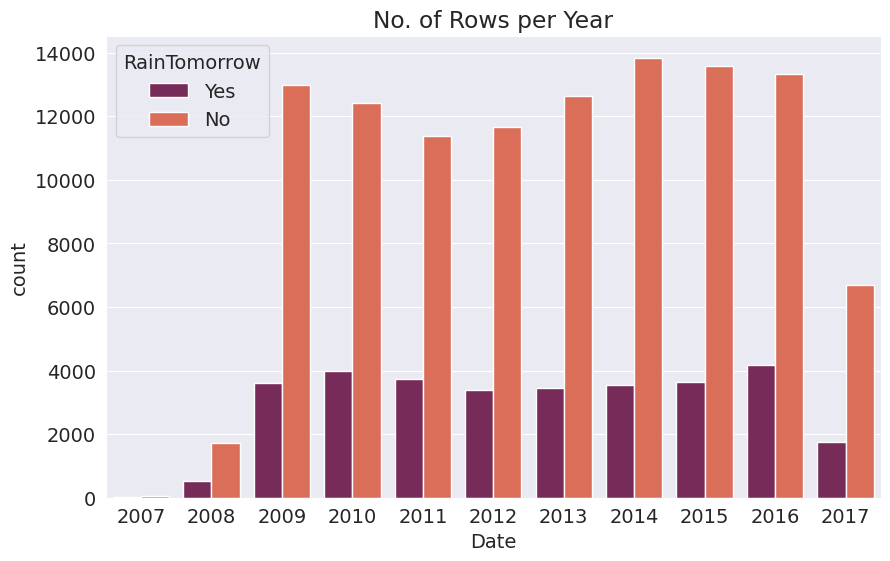

In [10]:
plt.title('No. of Rows per Year');
sns.countplot(data=df,x=pd.to_datetime(df.Date).dt.year,hue='RainTomorrow',palette='rocket');

##Spiliting of data based on time..year

In [11]:
year=pd.to_datetime(df['Date']).dt.year;
train_df=df[year<2015];
val_df=df[year==2015];
test_df=df[year>2015];

In [12]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (98988, 23)
val_df.shape : (17231, 23)
test_df.shape : (25974, 23)


In [13]:
input_cols=train_df.columns[1:-1].tolist()
target_cols='RainTomorrow'

train_inputs=train_df[input_cols].copy()
train_targets=train_df[target_cols].copy()

val_inputs=val_df[input_cols].copy()
val_targets=val_df[target_cols].copy()

test_inputs=test_df[input_cols].copy()
test_targets=test_df[target_cols].copy()

In [14]:
numerical_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

In [15]:
imputer=SimpleImputer(strategy='mean').fit(df[numerical_cols])

train_inputs[numerical_cols]=imputer.transform(train_inputs[numerical_cols])
val_inputs[numerical_cols]=imputer.transform(val_df[numerical_cols])
test_inputs[numerical_cols]=imputer.transform(test_inputs[numerical_cols])

In [16]:
#checking if numerical_cols have null values
train_inputs[numerical_cols].isnull().sum()

,0
MinTemp,0
MaxTemp,0
Rainfall,0
Evaporation,0
Sunshine,0
WindGustSpeed,0
WindSpeed9am,0
WindSpeed3pm,0
Humidity9am,0
Humidity3pm,0


# Scaling numerical data...

In [17]:
scaler=MinMaxScaler().fit(df[numerical_cols])
train_inputs[numerical_cols]=scaler.transform(train_inputs[numerical_cols])
val_inputs[numerical_cols]=scaler.transform(val_inputs[numerical_cols])
test_inputs[numerical_cols]=scaler.transform(test_inputs[numerical_cols])

#Encoding categorical columns

In [18]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols]=encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols]=encoder.transform(test_inputs[categorical_cols])
val_inputs.to_csv('val_inputs.csv',index=False)
test_inputs.to_csv('test_inputs.csv',index=False)

/tmp/ipython-input-2746625671.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
/tmp/ipython-input-2746625671.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
/tmp/ipython-input-2746625671.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

In [19]:
train_inputs.isnull().sum()
train_inputs.describe()
train_inputs.to_csv('TrainData.csv',index=False)


# Combining the numerical_cols and categorical_cols together....


In [20]:
X_train=train_inputs[numerical_cols +encoded_cols]
X_val=val_inputs[numerical_cols + encoded_cols]
X_test=test_inputs[numerical_cols + encoded_cols]

# Illustration of the DecisionTreeClassifier Operation..........

![Decision Tree Illustrations](https://i.imgur.com/qSH4lqz.png)

In [21]:
model=DecisionTreeClassifier(random_state=42)

In [22]:
model.fit(X_train,train_targets)

DecisionTreeClassifier(random_state=42)

#Predicition ......

In [23]:
train_preds=model.predict(X_train)

In [24]:
pd.value_counts(model.predict(X_train))

/tmp/ipython-input-4076448990.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(model.predict(X_train))


,count
No,76707
Yes,22281


# Metrics of the model

In [25]:
#Based on train_train and train_inputs
accuracy_score(train_targets,train_preds)

0.9999797955307714

In [26]:
#Based on val_targets and val_inputs
accuracy_score(val_targets,model.predict(X_val))

0.7921188555510418

# Plot the Tree

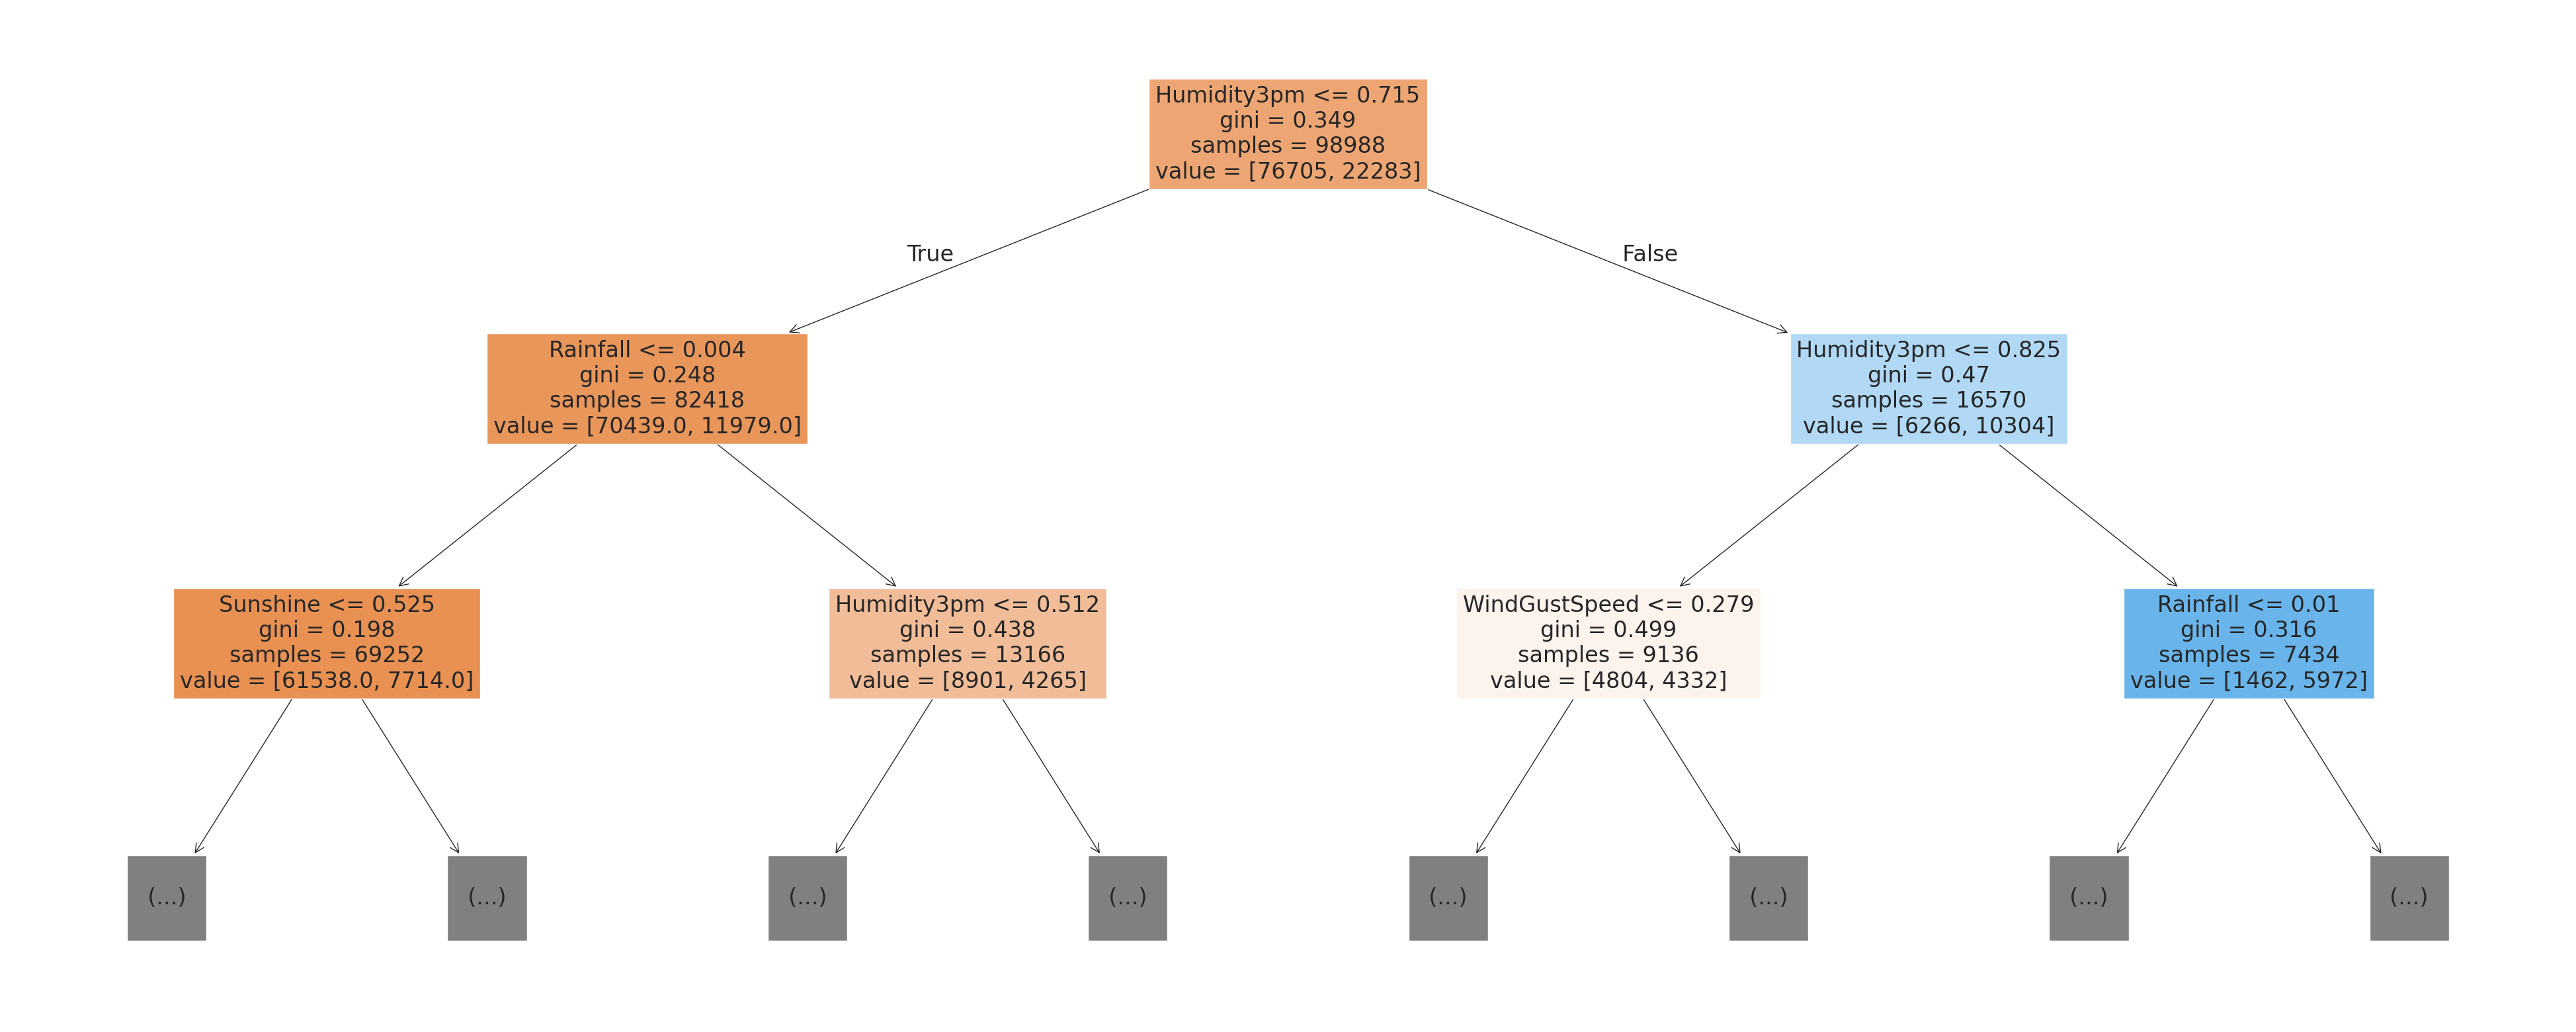

In [27]:
plt.figure(figsize=(50,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

In [28]:
tree_text=export_text(model,max_depth=10,feature_names=list(X_train.columns))
print(tree_text)

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |   |--- Cloud9am <= 0.83
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm >  0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |   |   |--- MinTemp <= 0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- MinTemp >  0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated